In [1]:
import setGPU

import torch
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

from torchvision.datasets import MNIST
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(4)
torch.autograd.set_detect_anomaly(True)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1,))])

batch_size = 128

X = MNIST("./mnist_dataset", train=True, download=True, transform=transform)
X_loaded = DataLoader(X, shuffle=True, batch_size=batch_size, pin_memory=True)

im_examples = 10

setGPU: Setting GPU to: 7


In [2]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return self.fc4(x)

In [3]:
G = Generator(100, 784).to(device)
D = Discriminator(784).to(device)

G_optimizer = optim.Adam(G.parameters(), lr=1e-4, weight_decay=5e-4)
D_optimizer = optim.Adam(D.parameters(), lr=1e-4, weight_decay=5e-4)

In [4]:
normal_dist = Normal(torch.tensor(0.).to(device), torch.tensor(0.2).to(device))
im_noise = normal_dist.sample((im_examples, 100))

In [5]:
def gen(num_samples, noise=0, disp=False):
    if(noise == 0):
        noise = normal_dist.sample((num_samples, 100))

    return G(noise)

In [6]:
#For plotting the losses for both networks at the end
def plotLoss():
    plt.figure(figsize=(10, 8))
    plt.plot(Dr_losses, label='Critic real loss')
    plt.plot(Df_losses, label='Critic fake loss')
    plt.plot(G_losses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
#We'll plot a sample of the generated images after each epoch
def plotGeneratedImages():
    dim=(1, im_examples+1)
    
    generated_images = G(im_noise)
    disc_output = D(generated_images)
    generated_images = generated_images.view(im_examples, 28, 28).cpu().detach().numpy()

    plt.figure(figsize=(im_examples+1, im_examples+1))

    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(np.zeros((28, 28)), cmap='gray_r')
    plt.axis('off')
    plt.text(-5,20,"Generated \n  Sample", fontsize=12)
    plt.text(-6,37,"Crit output", fontsize=12)

    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+2)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        val = "Real(%.1f)"%disc_output[i] if disc_output[i]>0.5 else "Fake(%.1f)"%disc_output[i]
        plt.text(5,37, val, fontsize=12)
        plt.axis('off')
    
    plt.show()

In [8]:
# from https://github.com/EmilienDupont/wgan-gp
def gradient_penalty(real_data, generated_data, batch_size):
    # Calculate interpolation
    alpha = torch.rand(batch_size, 1).to(device)
    alpha = alpha.expand_as(real_data)
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    interpolated = Variable(interpolated, requires_grad=True).to(device)

    del alpha
    torch.cuda.empty_cache()

    # Calculate probability of interpolated examples
    prob_interpolated = D(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated, grad_outputs=torch.ones(prob_interpolated.size()).to(device), create_graph=True, retain_graph=True, allow_unused=True)[0].to(device)

    gradients = gradients.contiguous()

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    gp = gp_weight * ((gradients_norm - 1) ** 2).mean()
    # print("gradient penalty")
    # print(gp)
    return gp

In [9]:
def train_D(data, gen_data=None):
    D.train()
    D_optimizer.zero_grad()

    run_batch_size = data.shape[0]

    if gen_data is None:
        gen_data = gen(run_batch_size)

    D_real_output = D(data)
    D_real_loss = -D_real_output.mean()
    D_real_loss.backward()

    D_fake_output = D(gen_data)
    D_fake_loss = D_fake_output.mean()
    D_fake_loss.backward()
    
    gp = gradient_penalty(data, gen_data, run_batch_size)
    gp.backward()
        
    D_optimizer.step()

    return (D_real_loss.item(), D_fake_loss.item())

In [10]:
def train_G(data):
    G.train()
    G_optimizer.zero_grad()

    gen_data = gen(batch_size)

    D_fake_output = D(gen_data)

    G_loss = -D_fake_output.mean()
    G_loss.backward()
    G_optimizer.step()

    return G_loss.item()

  0%|          | 1/469 [00:00<00:47,  9.91it/s]

Epoch 1


100%|██████████| 469/469 [00:43<00:00, 10.71it/s]


g loss: -0.3472209655876353
dr loss: -6.53341457437573
df loss: 0.5218603978596771


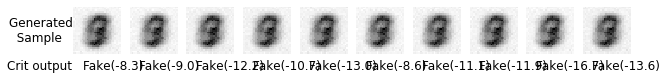

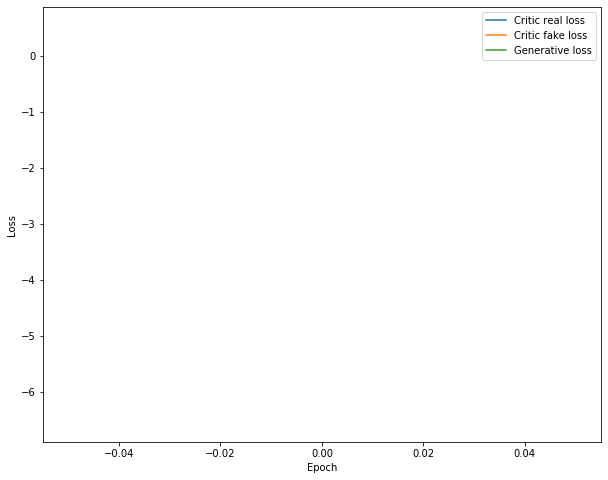

  0%|          | 2/469 [00:00<00:46, 10.11it/s]

Epoch 2


100%|██████████| 469/469 [00:43<00:00, 10.83it/s]


g loss: 0.5369150826234871
dr loss: -3.680696495909935
df loss: -0.5138637484498084


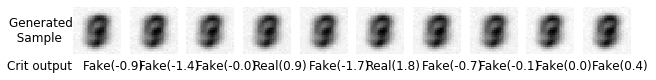

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3


100%|██████████| 469/469 [00:44<00:00, 10.61it/s]


g loss: -0.06605540457834949
dr loss: -5.540307009398048
df loss: 0.08894486211812191


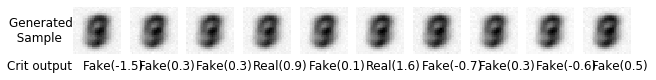

  0%|          | 2/469 [00:00<00:45, 10.30it/s]

Epoch 4


100%|██████████| 469/469 [00:43<00:00, 10.68it/s]


g loss: -0.19583267191532197
dr loss: -6.105152926211164
df loss: 0.20373485134497507


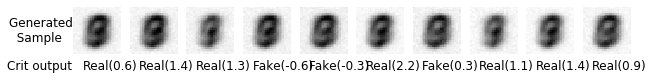

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5


100%|██████████| 469/469 [00:44<00:00, 10.55it/s]


g loss: -0.3415814174541723
dr loss: -6.105380175210265
df loss: 0.3559541890361924


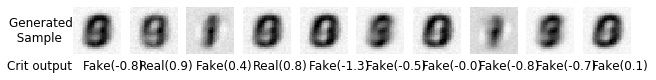

  0%|          | 2/469 [00:00<00:46, 10.14it/s]

Epoch 6


100%|██████████| 469/469 [00:43<00:00, 11.01it/s]


g loss: -0.11012613975893715
dr loss: -5.7263664457081225
df loss: 0.12284494822086302


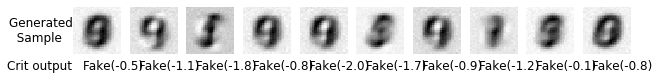

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7


100%|██████████| 469/469 [00:43<00:00, 11.22it/s]


g loss: -0.4754731107924158
dr loss: -5.890109452865779
df loss: 0.4879311438022392


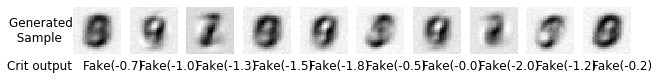

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8


100%|██████████| 469/469 [00:44<00:00, 11.16it/s]


g loss: 0.3987917528430155
dr loss: -4.941820161992998
df loss: -0.32839796382354014


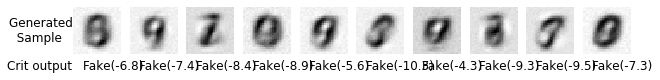

  0%|          | 2/469 [00:00<00:45, 10.17it/s]

Epoch 9


100%|██████████| 469/469 [00:43<00:00, 10.76it/s]


g loss: -0.031761362799195086
dr loss: -5.1080434347536645
df loss: 0.08179769764290944


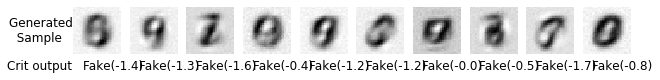

  0%|          | 2/469 [00:00<00:46, 10.06it/s]

Epoch 10


100%|██████████| 469/469 [00:44<00:00, 10.65it/s]


g loss: 0.629726563498918
dr loss: -4.217987233300263
df loss: -0.5866433179804257


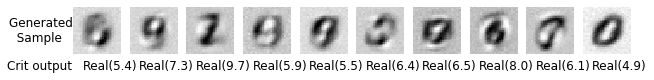

  0%|          | 2/469 [00:00<00:45, 10.27it/s]

Epoch 11


100%|██████████| 469/469 [00:43<00:00, 10.80it/s]


g loss: 0.6289030449476832
dr loss: -4.1049588480309005
df loss: -0.5649506941453607


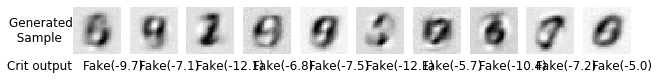

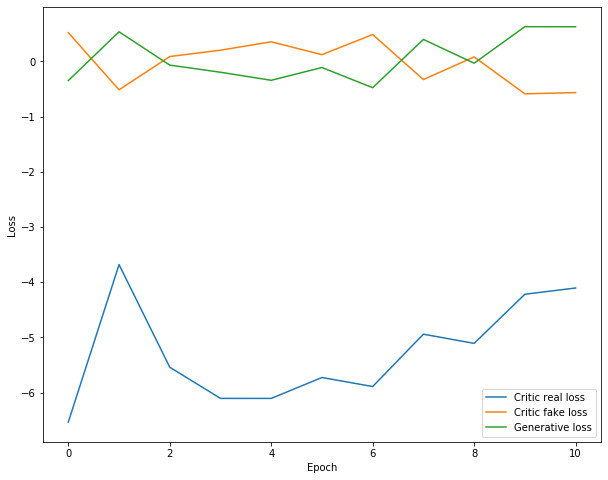

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12


100%|██████████| 469/469 [00:43<00:00, 11.00it/s]


g loss: 0.08216678158942062
dr loss: -4.308718225817437
df loss: -0.07791296534859804


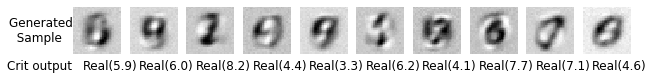

  0%|          | 2/469 [00:00<00:46,  9.99it/s]

Epoch 13


100%|██████████| 469/469 [00:43<00:00, 10.87it/s]


g loss: 0.2678006031175158
dr loss: -3.991366659972205
df loss: -0.20635716723147104


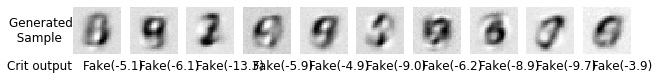

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14


100%|██████████| 469/469 [00:44<00:00, 10.64it/s]


g loss: 0.7748178208568521
dr loss: -3.2986246949828257
df loss: -0.7361161085659824


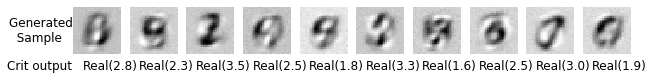

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15


100%|██████████| 469/469 [00:43<00:00, 10.67it/s]


g loss: -0.2856053400840332
dr loss: -4.224787017088264
df loss: 0.28573823901318285


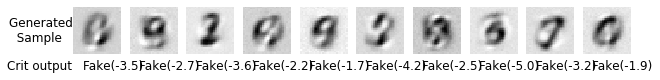

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16


100%|██████████| 469/469 [00:43<00:00, 11.14it/s]


g loss: 1.0192451354707959
dr loss: -2.8295262293465164
df loss: -0.9826267757284235


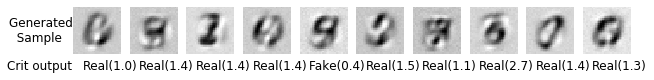

  0%|          | 2/469 [00:00<00:46, 10.04it/s]

Epoch 17


100%|██████████| 469/469 [00:43<00:00, 10.75it/s]


g loss: 0.014318898479059053
dr loss: -3.6986975164762312
df loss: 0.01948468719940704


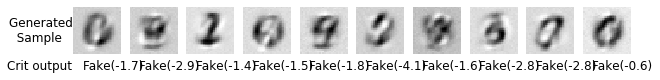

  0%|          | 2/469 [00:00<00:45, 10.30it/s]

Epoch 18


100%|██████████| 469/469 [00:43<00:00, 10.81it/s]


g loss: 0.586568163092266
dr loss: -2.9806182262168
df loss: -0.570502158112403


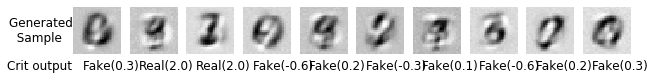

  0%|          | 2/469 [00:00<00:45, 10.34it/s]

Epoch 19


100%|██████████| 469/469 [00:44<00:00, 10.64it/s]


g loss: 0.3393610550471937
dr loss: -3.148085022023492
df loss: -0.3220378920308817


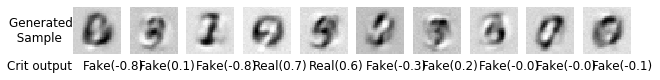

  0%|          | 2/469 [00:00<00:45, 10.35it/s]

Epoch 20


100%|██████████| 469/469 [00:43<00:00, 11.03it/s]


g loss: 0.30223295750862944
dr loss: -3.113898694896495
df loss: -0.2895479484606209


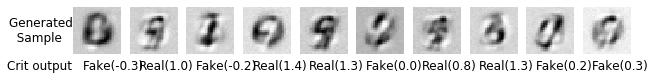

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21


100%|██████████| 469/469 [00:44<00:00, 10.60it/s]


g loss: 0.4276740947353052
dr loss: -2.9781239856280752
df loss: -0.4098930393975141


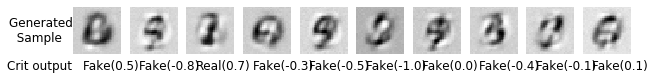

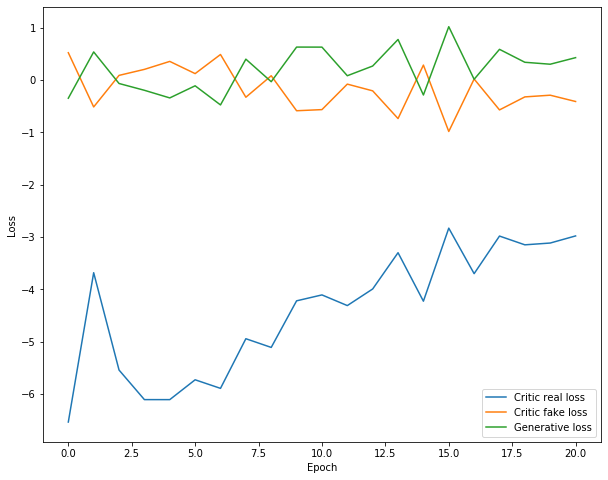

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22


100%|██████████| 469/469 [00:43<00:00, 10.72it/s]


g loss: 0.5856940203082206
dr loss: -2.753550082635778
df loss: -0.573725190198323


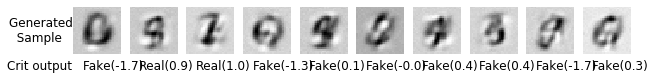

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23


100%|██████████| 469/469 [00:44<00:00, 10.63it/s]


g loss: 0.415459984699006
dr loss: -2.8908579834997017
df loss: -0.4018162794307923


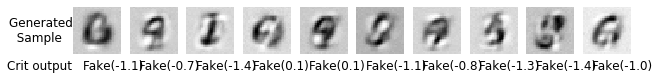

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24


100%|██████████| 469/469 [00:43<00:00, 10.66it/s]


g loss: 0.6302321461964645
dr loss: -2.637397971361685
df loss: -0.6139824620720102


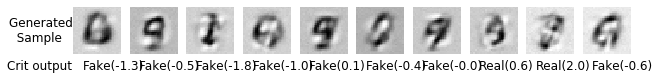

  0%|          | 2/469 [00:00<00:45, 10.28it/s]

Epoch 25


100%|██████████| 469/469 [00:43<00:00, 10.78it/s]


g loss: 0.5924704283285243
dr loss: -2.6342748008303043
df loss: -0.5767470227478981


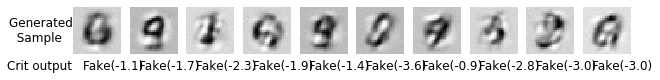

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26


100%|██████████| 469/469 [00:43<00:00, 10.87it/s]


g loss: 0.6559407349620293
dr loss: -2.481416235600453
df loss: -0.6607114476944084


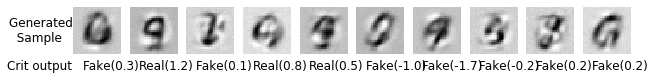

  0%|          | 2/469 [00:00<00:46, 10.10it/s]

Epoch 27


100%|██████████| 469/469 [00:43<00:00, 10.78it/s]


g loss: 1.022467733001404
dr loss: -2.117662556850707
df loss: -1.0137681025844902


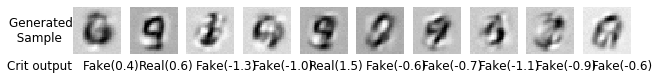

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28


100%|██████████| 469/469 [00:44<00:00, 10.60it/s]


g loss: 1.166477993305431
dr loss: -1.9216814004798244
df loss: -1.1241038685311069


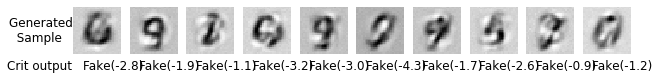

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29


100%|██████████| 469/469 [00:44<00:00, 10.54it/s]


g loss: 1.2063269952594091
dr loss: -1.8117273442232724
df loss: -1.1785507862255582


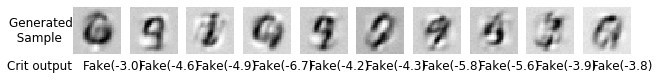

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30


100%|██████████| 469/469 [00:44<00:00, 10.96it/s]


g loss: 1.5208852726783453
dr loss: -1.4841538003322159
df loss: -1.4770591790631


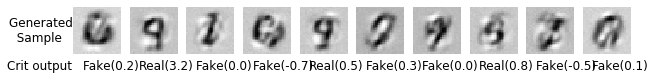

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31


100%|██████████| 469/469 [00:44<00:00, 10.64it/s]


g loss: 1.9132967571269222
dr loss: -1.0488478921171127
df loss: -1.8930483638072637


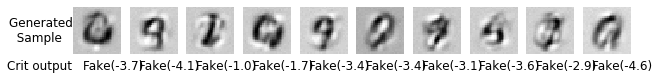

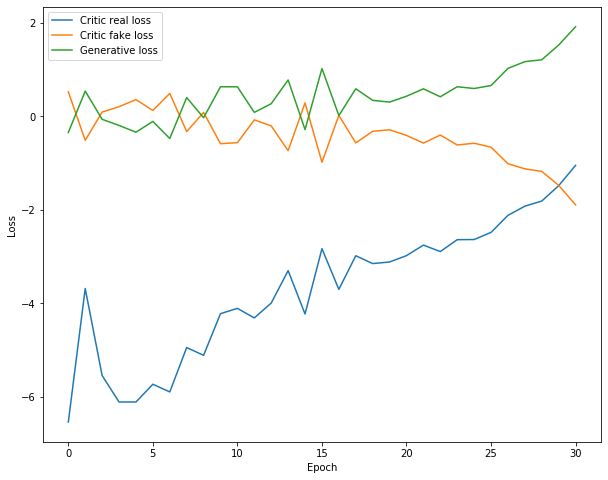

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32


100%|██████████| 469/469 [00:44<00:00, 10.54it/s]


g loss: 2.0380582666096054
dr loss: -0.8844631224560903
df loss: -2.012297706348873


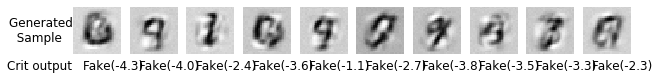

  0%|          | 2/469 [00:00<00:45, 10.34it/s]

Epoch 33


100%|██████████| 469/469 [00:44<00:00,  9.93it/s]


g loss: 2.64573045758042
dr loss: -0.15682393923274743
df loss: -2.618124278877844


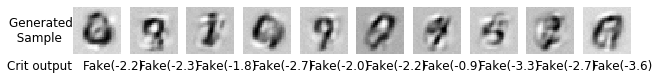

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34


100%|██████████| 469/469 [00:44<00:00, 10.65it/s]


g loss: 2.8001397276229696
dr loss: 0.07678054981251388
df loss: -2.7795569891614447


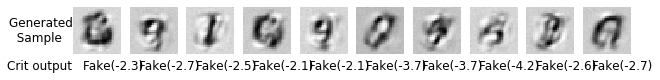

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35


100%|██████████| 469/469 [00:43<00:00, 10.67it/s]


g loss: 3.0593001486650153
dr loss: 0.3980814597126581
df loss: -3.014356580116093


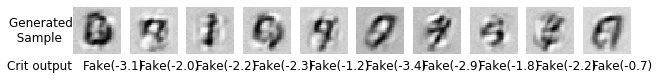

  0%|          | 2/469 [00:00<00:45, 10.18it/s]

Epoch 36


100%|██████████| 469/469 [00:44<00:00, 10.60it/s]


g loss: 2.9492890288326534
dr loss: 0.32556397196993647
df loss: -2.9158287594821664


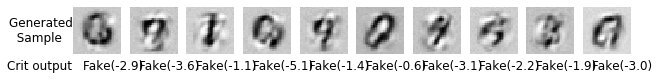

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37


100%|██████████| 469/469 [00:44<00:00, 10.46it/s]


g loss: 2.496819109804849
dr loss: -0.1111259437136368
df loss: -2.4625903831870315


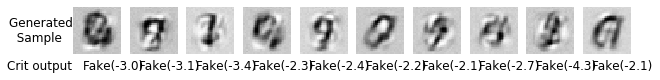

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38


100%|██████████| 469/469 [00:43<00:00, 10.69it/s]


g loss: 2.3810737378307496
dr loss: -0.19452144489137094
df loss: -2.351853573246043


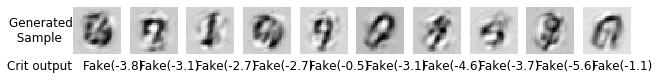

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39


100%|██████████| 469/469 [00:43<00:00,  9.95it/s]


g loss: 2.240417341687786
dr loss: -0.2834929852251972
df loss: -2.2267801614204195


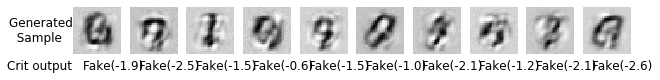

  0%|          | 2/469 [00:00<00:46, 10.15it/s]

Epoch 40


100%|██████████| 469/469 [00:43<00:00, 11.25it/s]


g loss: 2.05360404718151
dr loss: -0.46557549733930687
df loss: -2.011091914766633


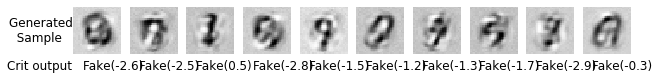

  0%|          | 2/469 [00:00<00:45, 10.17it/s]

Epoch 41


100%|██████████| 469/469 [00:43<00:00, 10.52it/s]


g loss: 1.8010205780265174
dr loss: -0.7060042273626526
df loss: -1.7798023195917418


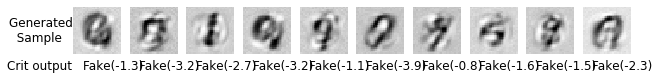

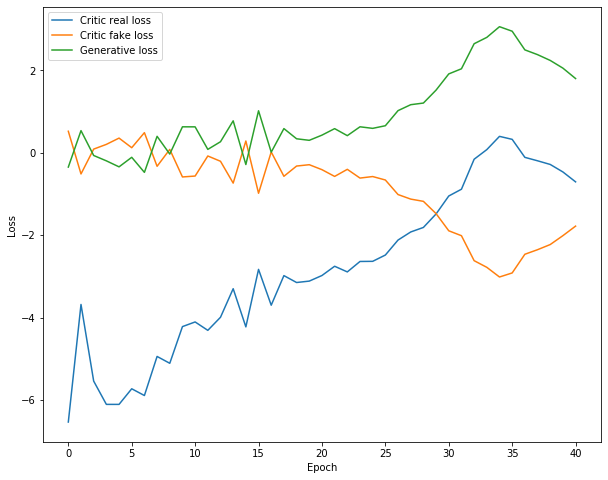

  0%|          | 2/469 [00:00<00:44, 10.42it/s]

Epoch 42


100%|██████████| 469/469 [00:43<00:00,  9.67it/s]


g loss: 1.7508544626711275
dr loss: -0.7390411156557326
df loss: -1.7314137136861523


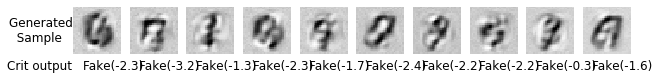

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43


100%|██████████| 469/469 [00:43<00:00, 10.69it/s]


g loss: 1.773317894622334
dr loss: -0.7835571224580823
df loss: -1.7288481939647562


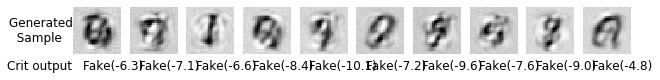

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44


100%|██████████| 469/469 [00:43<00:00, 11.13it/s]


g loss: 2.068427617012311
dr loss: -0.91394466000484
df loss: -1.9497958133175874


  0%|          | 2/469 [00:00<00:46, 10.07it/s]

Epoch 45


100%|██████████| 469/469 [00:43<00:00, 10.68it/s]


g loss: 0.6119628225181148
dr loss: -2.03560106430862
df loss: -0.5636070624295709


  0%|          | 1/469 [00:00<00:51,  9.16it/s]

Epoch 46


100%|██████████| 469/469 [00:43<00:00, 10.35it/s]


g loss: 1.4113200206095096
dr loss: -1.1166347936947527
df loss: -1.390994728286701


  0%|          | 2/469 [00:00<00:46, 10.11it/s]

Epoch 47


100%|██████████| 469/469 [00:44<00:00, 11.15it/s]


g loss: 2.008541991461569
dr loss: -0.46924045670038855
df loss: -2.003384580744355


  0%|          | 2/469 [00:00<00:46, 10.15it/s]

Epoch 48


100%|██████████| 469/469 [00:43<00:00, 10.86it/s]


g loss: 2.4168673659692694
dr loss: -0.03045572261256513
df loss: -2.4081505465863358


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49


100%|██████████| 469/469 [00:44<00:00, 11.03it/s]


g loss: 2.2759662419239852
dr loss: -0.1668127488150303
df loss: -2.2488219252527397


  0%|          | 2/469 [00:00<00:46, 10.11it/s]

Epoch 50


100%|██████████| 469/469 [00:43<00:00, 10.28it/s]


g loss: 2.0388966913162263
dr loss: -0.34796137561294826
df loss: -2.012174371717327


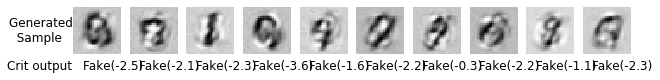

  0%|          | 2/469 [00:00<00:45, 10.33it/s]

Epoch 51


100%|██████████| 469/469 [00:43<00:00, 10.81it/s]


g loss: 2.0046205370665104
dr loss: -0.35122470326546923
df loss: -1.9754962196736447


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52


100%|██████████| 469/469 [00:43<00:00, 10.08it/s]


g loss: 1.7347087865190973
dr loss: -0.5951233751166349
df loss: -1.7144935809727162


  0%|          | 2/469 [00:00<00:46, 10.09it/s]

Epoch 53


100%|██████████| 469/469 [00:44<00:00, 10.55it/s]


g loss: 1.5843541637412522
dr loss: -0.7451974884358677
df loss: -1.567267720124869


  0%|          | 2/469 [00:00<00:46, 10.10it/s]

Epoch 54


100%|██████████| 469/469 [00:43<00:00, 10.71it/s]


g loss: 1.3867073336135605
dr loss: -0.9280195349950526
df loss: -1.3742971449518508


  0%|          | 2/469 [00:00<00:45, 10.34it/s]

Epoch 55


100%|██████████| 469/469 [00:43<00:00, 11.02it/s]


g loss: 1.3271547533047479
dr loss: -0.9943729941842399
df loss: -1.3090486545552578


  0%|          | 2/469 [00:00<00:46, 10.07it/s]

Epoch 56


100%|██████████| 469/469 [00:44<00:00, 10.61it/s]


g loss: 1.398452778360737
dr loss: -0.8966618696890915
df loss: -1.3804967018968262


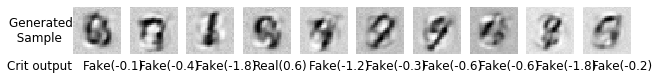

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57


100%|██████████| 469/469 [00:44<00:00, 10.78it/s]


g loss: 1.4283918819702002
dr loss: -0.8420499630653655
df loss: -1.415799064676899


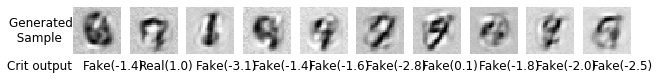

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58


100%|██████████| 469/469 [00:44<00:00, 10.60it/s]


g loss: 1.2653033260597604
dr loss: -1.0131644261623625
df loss: -1.2406567290012263


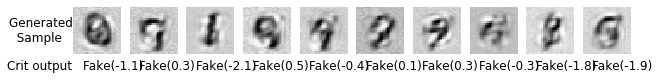

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59


100%|██████████| 469/469 [00:43<00:00, 10.53it/s]


g loss: 1.4333809776378594
dr loss: -0.8529773236079606
df loss: -1.4015797094674285


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60


100%|██████████| 469/469 [00:44<00:00, 10.56it/s]


g loss: 1.592238891456745
dr loss: -0.7579927587988915
df loss: -1.5482305594995966


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61


100%|██████████| 469/469 [00:43<00:00, 10.88it/s]


g loss: 1.1524837862835255
dr loss: -1.362352920406218
df loss: -1.1107616298345488


  0%|          | 2/469 [00:00<00:45, 10.24it/s]

Epoch 62


100%|██████████| 469/469 [00:43<00:00, 10.90it/s]


g loss: 1.4455365058757477
dr loss: -0.9098185144865246
df loss: -1.4270415687278262


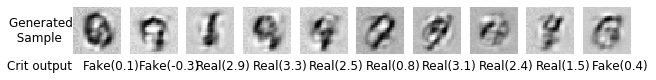

  0%|          | 2/469 [00:00<00:46, 10.14it/s]

Epoch 63


100%|██████████| 469/469 [00:44<00:00, 10.71it/s]


g loss: 1.480050369231368
dr loss: -0.7805026050553774
df loss: -1.4436148078933453


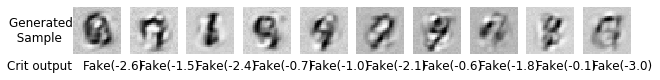

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 64


100%|██████████| 469/469 [00:45<00:00, 10.80it/s]


g loss: 1.9145756349888947
dr loss: -0.33364579042614395
df loss: -1.8921864314882486


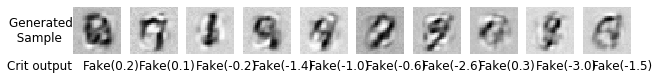

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65


100%|██████████| 469/469 [00:45<00:00, 10.32it/s]


g loss: 2.1218575661116317
dr loss: -0.11135762392569071
df loss: -2.087833348621946


  0%|          | 2/469 [00:00<00:46, 10.08it/s]

Epoch 66


100%|██████████| 469/469 [00:44<00:00, 10.95it/s]


g loss: 2.1480799496555125
dr loss: -0.029947325209977785
df loss: -2.1377600123887377


  0%|          | 2/469 [00:00<00:46, 10.13it/s]

Epoch 67


100%|██████████| 469/469 [00:44<00:00, 10.61it/s]


g loss: 2.1900109683018503
dr loss: 0.0306777868475487
df loss: -2.1759698627345854


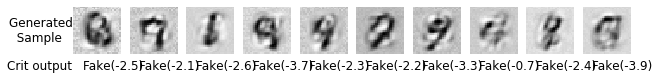

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68


100%|██████████| 469/469 [00:44<00:00, 10.57it/s]


g loss: 1.9957651321821885
dr loss: -0.16011466047387007
df loss: -1.9844059384962134


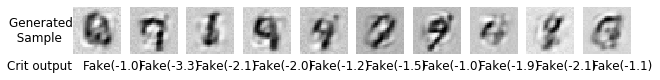

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69


100%|██████████| 469/469 [00:42<00:00,  9.44it/s]


g loss: 1.9780320488313623
dr loss: -0.17910321755235448
df loss: -1.9525031461390352


  0%|          | 2/469 [00:00<00:45, 10.30it/s]

Epoch 70


100%|██████████| 469/469 [00:43<00:00, 10.92it/s]


g loss: 1.92423630624946
dr loss: -0.23080791848530965
df loss: -1.9081383486038077


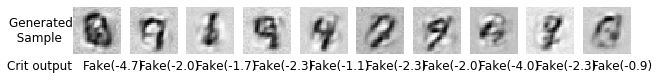

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 71


100%|██████████| 469/469 [00:43<00:00, 11.01it/s]


g loss: 1.7981757601695274
dr loss: -0.33728963210543333
df loss: -1.7783700098106856


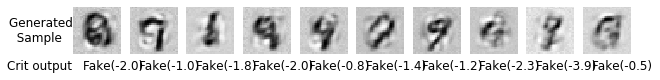

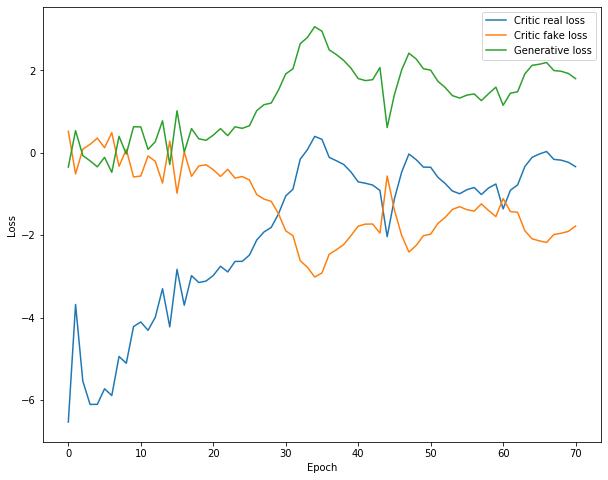

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 72


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


g loss: 1.5789994476700644
dr loss: -0.53922956623137
df loss: -1.553576848273084


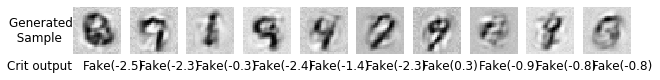

  0%|          | 2/469 [00:00<00:46, 10.05it/s]

Epoch 73


100%|██████████| 469/469 [00:43<00:00, 10.90it/s]


g loss: 1.6293484900297641
dr loss: -0.49922747404844775
df loss: -1.58530293853044


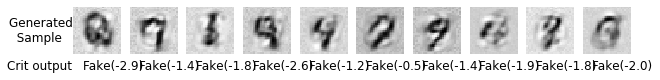

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 74


100%|██████████| 469/469 [00:43<00:00, 10.79it/s]


g loss: 1.4246602257940053
dr loss: -0.6787438423418478
df loss: -1.3865884977744332


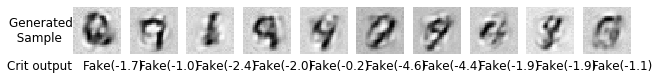

  0%|          | 2/469 [00:00<00:44, 10.40it/s]

Epoch 75


100%|██████████| 469/469 [00:43<00:00, 10.84it/s]


g loss: 1.3880448255822984
dr loss: -0.7190969472151321
df loss: -1.3731600340636474


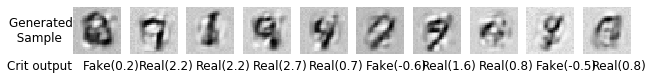

  0%|          | 2/469 [00:00<00:44, 10.39it/s]

Epoch 76


100%|██████████| 469/469 [00:43<00:00, 10.95it/s]


g loss: 1.4157945909368586
dr loss: -0.711934381702752
df loss: -1.3863561203135357


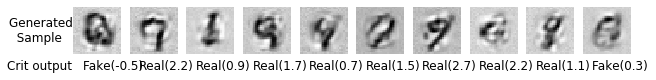

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 77


100%|██████████| 469/469 [00:44<00:00, 10.49it/s]


g loss: 1.1639596131056358
dr loss: -1.0760417631440071
df loss: -1.09475893995115


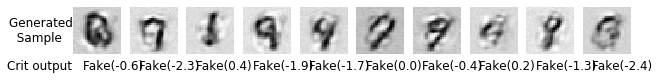

  0%|          | 2/469 [00:00<00:46, 10.12it/s]

Epoch 78


100%|██████████| 469/469 [00:44<00:00, 10.63it/s]


g loss: 1.526400311919513
dr loss: -0.6394789299524543
df loss: -1.4901624644306233


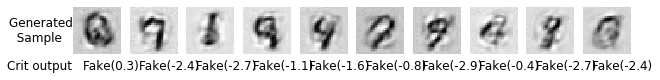

  0%|          | 2/469 [00:00<00:46, 10.12it/s]

Epoch 79


100%|██████████| 469/469 [00:43<00:00, 10.74it/s]


g loss: 1.413833558607076
dr loss: -0.6853082471811123
df loss: -1.3953306815827262


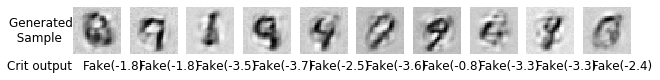

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 80


100%|██████████| 469/469 [00:44<00:00, 10.60it/s]


g loss: 1.6872828588811066
dr loss: -0.36887766376558717
df loss: -1.676398873074985


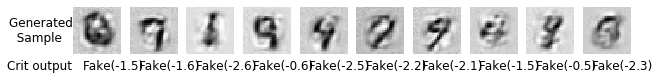

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 81


100%|██████████| 469/469 [00:44<00:00, 10.50it/s]


g loss: 1.7766960908863336
dr loss: -0.2649636790831524
df loss: -1.7576802460623702


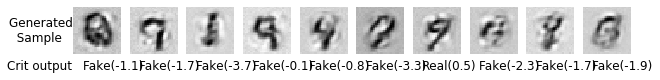

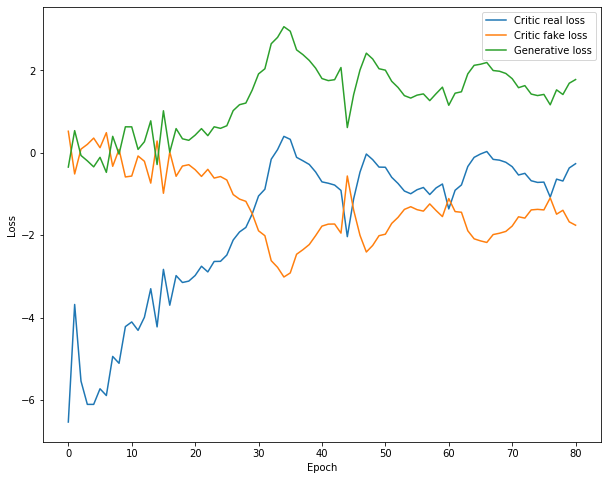

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 82


100%|██████████| 469/469 [00:44<00:00, 10.54it/s]


g loss: 1.696808565654226
dr loss: -0.31604843939354677
df loss: -1.6768457310031981


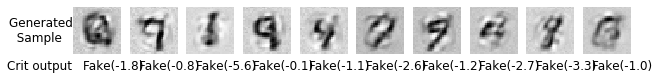

  0%|          | 2/469 [00:00<00:46, 10.14it/s]

Epoch 83


100%|██████████| 469/469 [00:44<00:00, 10.51it/s]


g loss: 1.6463460241045271
dr loss: -0.37513384699170144
df loss: -1.6069654835058427


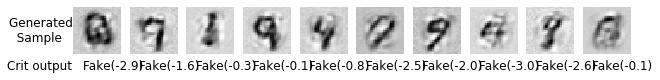

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 84


100%|██████████| 469/469 [00:43<00:00, 11.24it/s]


g loss: 1.3551012431380591
dr loss: -0.6410744412303734
df loss: -1.3320479023176979


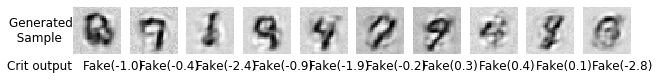

  0%|          | 2/469 [00:00<00:45, 10.31it/s]

Epoch 85


100%|██████████| 469/469 [00:43<00:00, 10.85it/s]


g loss: 1.2550525707222506
dr loss: -0.7130085672698677
df loss: -1.238982800291037


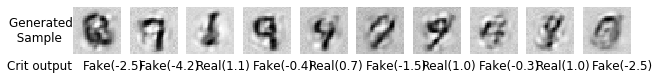

  0%|          | 2/469 [00:00<00:45, 10.31it/s]

Epoch 86


100%|██████████| 469/469 [00:42<00:00, 11.00it/s]


g loss: 1.15347447425826
dr loss: -0.7950060809535513
df loss: -1.1465834327725206


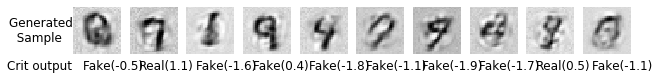

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 87


100%|██████████| 469/469 [00:43<00:00, 11.22it/s]


g loss: 1.2165235818576203
dr loss: -0.7271696469788231
df loss: -1.2156478118921903


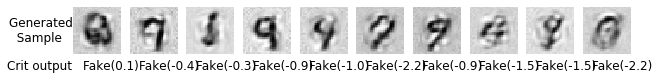

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 88


100%|██████████| 469/469 [00:42<00:00, 11.06it/s]


g loss: 1.154602942332975
dr loss: -0.8173756969175232
df loss: -1.1323536389004956


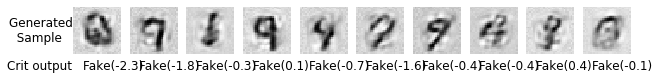

  0%|          | 2/469 [00:00<00:46, 10.05it/s]

Epoch 89


100%|██████████| 469/469 [00:42<00:00, 11.05it/s]


g loss: 1.1260272572234051
dr loss: -0.8673430404175065
df loss: -1.0934117310749951


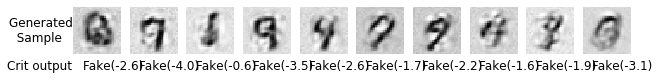

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 90


100%|██████████| 469/469 [00:42<00:00, 11.07it/s]


g loss: 0.9086422556276514
dr loss: -1.1073451933147176
df loss: -0.8666822704603709


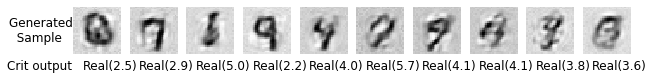

  0%|          | 2/469 [00:00<00:45, 10.38it/s]

Epoch 91


100%|██████████| 469/469 [00:42<00:00, 10.87it/s]


g loss: 0.9626645462186352
dr loss: -1.1308366325237096
df loss: -0.9046420116605026


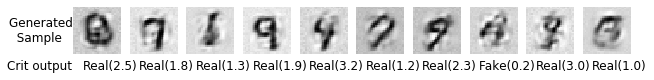

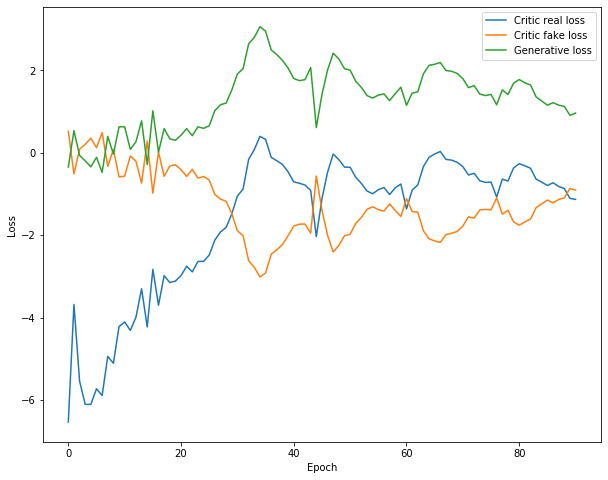

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 92


100%|██████████| 469/469 [00:42<00:00, 11.39it/s]


g loss: 1.113856979159277
dr loss: -0.8772173012767647
df loss: -1.066203312465806


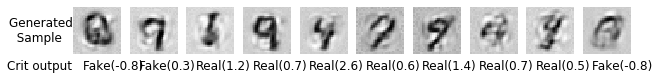

  0%|          | 2/469 [00:00<00:44, 10.42it/s]

Epoch 93


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


g loss: 1.4378224331925291
dr loss: -0.49745832771253484
df loss: -1.4238987982090412


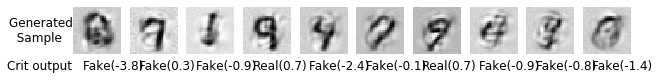

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 94


100%|██████████| 469/469 [00:43<00:00, 11.41it/s]


g loss: 1.654182559391583
dr loss: -0.28178530353417336
df loss: -1.646635966133207


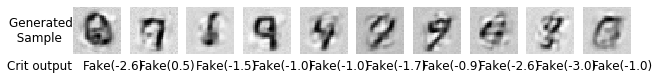

  0%|          | 2/469 [00:00<00:45, 10.26it/s]

Epoch 95


100%|██████████| 469/469 [00:42<00:00, 11.38it/s]


g loss: 1.6541425404009789
dr loss: -0.2667494731933387
df loss: -1.6269960754207458


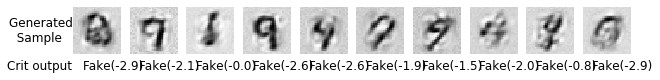

  0%|          | 2/469 [00:00<00:45, 10.23it/s]

Epoch 96


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


g loss: 1.4786571518444558
dr loss: -0.4593484931762443
df loss: -1.4429111694222065


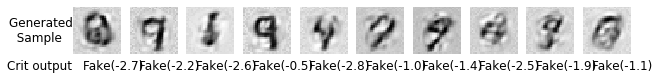

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 97


100%|██████████| 469/469 [00:42<00:00, 11.34it/s]


g loss: 1.4791832155764484
dr loss: -0.4366499312253776
df loss: -1.4407551822377676


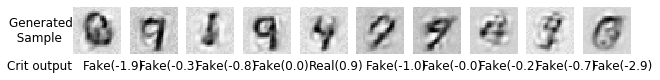

  0%|          | 2/469 [00:00<00:45, 10.22it/s]

Epoch 98


100%|██████████| 469/469 [00:42<00:00, 11.00it/s]


g loss: 1.1149896802043102
dr loss: -0.7654790954509461
df loss: -1.1058102906512808


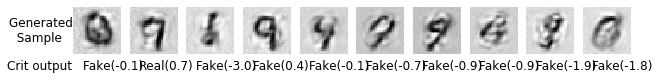

  0%|          | 2/469 [00:00<00:46, 10.06it/s]

Epoch 99


100%|██████████| 469/469 [00:42<00:00, 11.08it/s]


g loss: 0.8990214139159555
dr loss: -0.9843258831038404
df loss: -0.8803672411802735


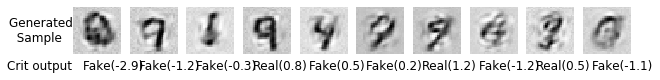

  0%|          | 2/469 [00:00<00:44, 10.44it/s]

Epoch 100


100%|██████████| 469/469 [00:42<00:00, 11.17it/s]


g loss: 0.9791975021997749
dr loss: -0.9218004215627845
df loss: -0.9496949159387332


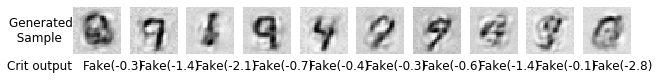

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 101


100%|██████████| 469/469 [00:42<00:00, 11.00it/s]


g loss: 0.7736500654456967
dr loss: -1.0947038224383967
df loss: -0.7532105934835954


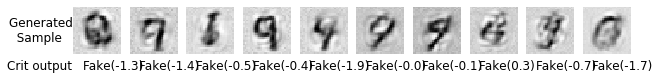

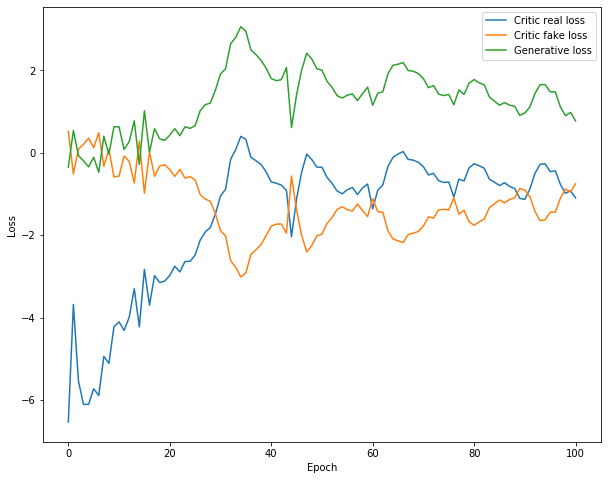

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 102


100%|██████████| 469/469 [00:42<00:00, 10.92it/s]


g loss: 0.5156266214901896
dr loss: -1.3717392919890916
df loss: -0.47980274479272267


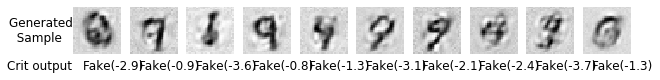

  0%|          | 2/469 [00:00<00:46, 10.12it/s]

Epoch 103


100%|██████████| 469/469 [00:42<00:00, 11.00it/s]


g loss: 0.4990878539966114
dr loss: -1.4594677407771095
df loss: -0.4706128281908535


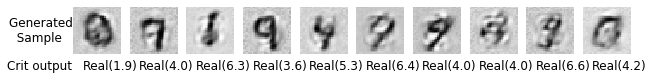

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 104


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


g loss: 0.553421012914257
dr loss: -1.4292342662334696
df loss: -0.5027606150727155


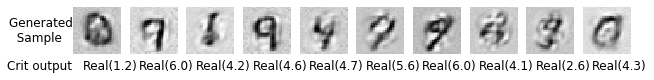

  0%|          | 2/469 [00:00<00:45, 10.35it/s]

Epoch 105


100%|██████████| 469/469 [00:42<00:00, 10.77it/s]


g loss: 0.3478244368407899
dr loss: -1.5067143809796968
df loss: -0.3314790426413896


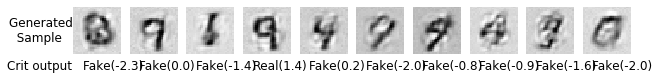

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 106


100%|██████████| 469/469 [00:42<00:00, 11.12it/s]


g loss: 0.7276085499268986
dr loss: -1.1435480165257574
df loss: -0.7015145673895123


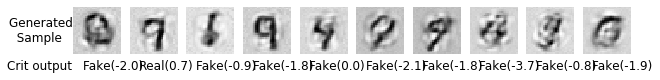

  0%|          | 2/469 [00:00<00:45, 10.26it/s]

Epoch 107


100%|██████████| 469/469 [00:41<00:00, 11.53it/s]


g loss: 1.0736785447800845
dr loss: -0.7682582262808135
df loss: -1.0598563089299557


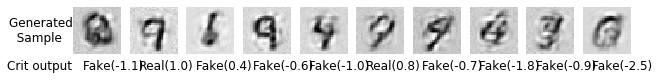

  0%|          | 2/469 [00:00<00:44, 10.51it/s]

Epoch 108


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


g loss: 1.1684626664942517
dr loss: -0.666880839526145
df loss: -1.1419093160232756


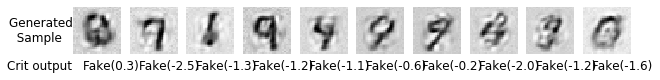

  0%|          | 2/469 [00:00<00:44, 10.53it/s]

Epoch 109


100%|██████████| 469/469 [00:42<00:00, 11.25it/s]


g loss: 1.103529170123753
dr loss: -0.724051047744019
df loss: -1.0663877170223164


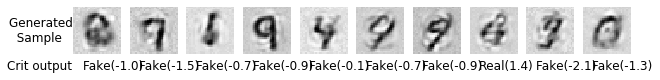

  0%|          | 2/469 [00:00<00:45, 10.20it/s]

Epoch 110


100%|██████████| 469/469 [00:42<00:00, 11.08it/s]


g loss: 0.6754002411132937
dr loss: -1.1385687385032426
df loss: -0.6538021932405703


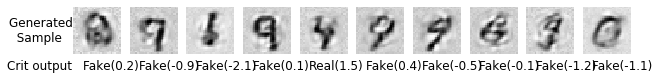

  0%|          | 2/469 [00:00<00:45, 10.32it/s]

Epoch 111


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


g loss: 0.5655425669414911
dr loss: -1.2572319163188244
df loss: -0.5437545596536543


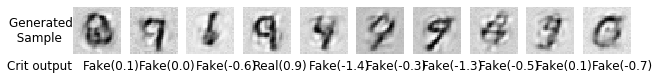

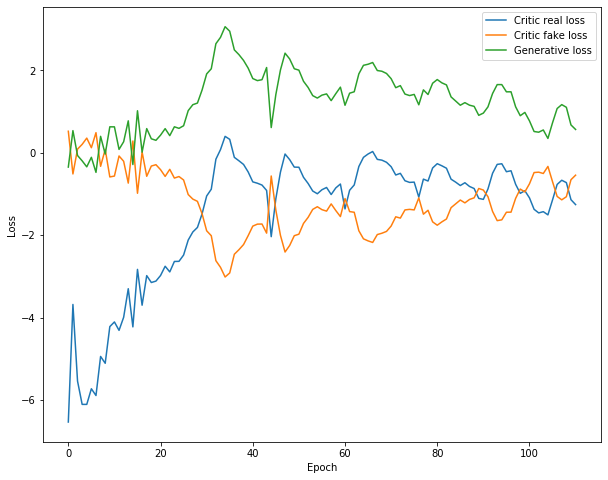

  0%|          | 2/469 [00:00<00:44, 10.45it/s]

Epoch 112


100%|██████████| 469/469 [00:41<00:00, 11.53it/s]


g loss: 0.5791415866496149
dr loss: -1.2264540592617572
df loss: -0.5651327501704444


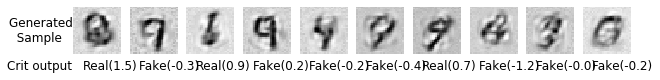

  0%|          | 2/469 [00:00<00:44, 10.49it/s]

Epoch 113


100%|██████████| 469/469 [00:41<00:00, 11.21it/s]


g loss: 0.4617616587054374
dr loss: -1.3117805181790008
df loss: -0.46208760523394166


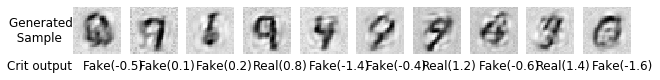

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 114


100%|██████████| 469/469 [00:42<00:00, 11.39it/s]


g loss: 0.34799996848855574
dr loss: -1.4372851175349404
df loss: -0.3431266464892703


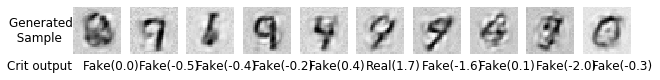

  0%|          | 2/469 [00:00<00:45, 10.32it/s]

Epoch 115


100%|██████████| 469/469 [00:42<00:00, 11.38it/s]


g loss: 0.3506661984505557
dr loss: -1.4557298853961644
df loss: -0.3184802868385623


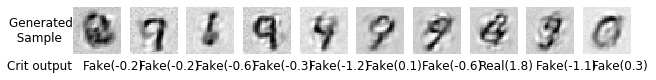

  0%|          | 2/469 [00:00<00:45, 10.34it/s]

Epoch 116


100%|██████████| 469/469 [00:41<00:00, 11.13it/s]


g loss: 0.47876224987137356
dr loss: -1.3021216054778617
df loss: -0.453769091042136


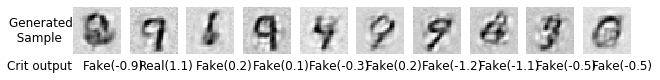

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 117


100%|██████████| 469/469 [00:41<00:00, 11.29it/s]


g loss: 0.29712998600148444
dr loss: -1.5044936107864766
df loss: -0.25827897494154445


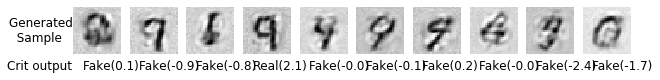

  0%|          | 2/469 [00:00<00:44, 10.52it/s]

Epoch 118


100%|██████████| 469/469 [00:42<00:00, 11.02it/s]


g loss: -0.02388284555566845
dr loss: -1.8934979317213363
df loss: 0.07501723676888165


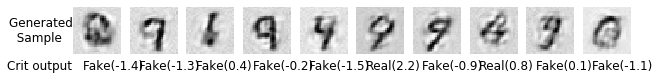

  0%|          | 2/469 [00:00<00:45, 10.29it/s]

Epoch 119


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


g loss: 0.228746849686098
dr loss: -1.6465786465290766
df loss: -0.1798726532981594


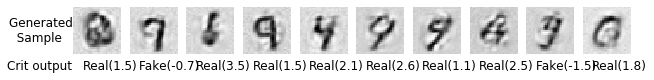

  0%|          | 2/469 [00:00<00:43, 10.62it/s]

Epoch 120


100%|██████████| 469/469 [00:41<00:00, 11.08it/s]


g loss: 0.7085459413272994
dr loss: -1.0929747397886282
df loss: -0.67240915814641


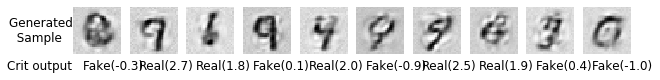

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 121


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


g loss: 0.6060994371795642
dr loss: -1.1560352822579045
df loss: -0.5754901183479185


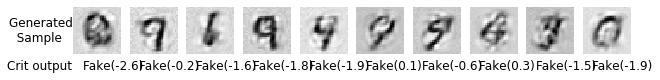

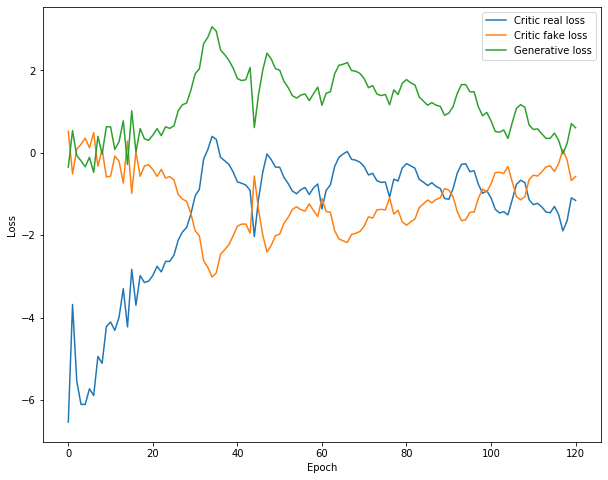

  0%|          | 2/469 [00:00<00:44, 10.47it/s]

Epoch 122


100%|██████████| 469/469 [00:42<00:00, 11.17it/s]


g loss: 0.6587825536028917
dr loss: -1.0973099595956457
df loss: -0.6496256123473649


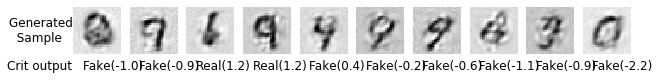

  0%|          | 2/469 [00:00<00:45, 10.24it/s]

Epoch 123


100%|██████████| 469/469 [00:42<00:00, 11.07it/s]


g loss: 0.5831670709379287
dr loss: -1.153012741476234
df loss: -0.5791958939832157


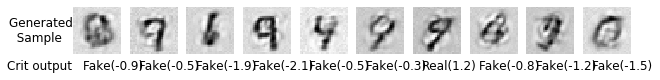

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 124


100%|██████████| 469/469 [00:42<00:00, 11.11it/s]


g loss: 0.5068495966938894
dr loss: -1.2173851340818507
df loss: -0.513422419146291


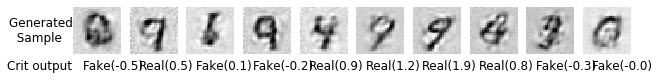

  0%|          | 2/469 [00:00<00:45, 10.31it/s]

Epoch 125


100%|██████████| 469/469 [00:42<00:00, 11.35it/s]


g loss: 0.28347245534695287
dr loss: -1.4400470841413877
df loss: -0.26024738207324416


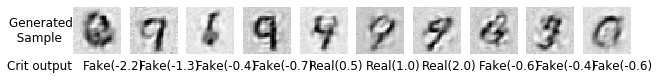

  0%|          | 2/469 [00:00<00:45, 10.31it/s]

Epoch 126


100%|██████████| 469/469 [00:41<00:00, 11.26it/s]


g loss: 0.23988486577405224
dr loss: -1.4773667712709797
df loss: -0.21707269330538792


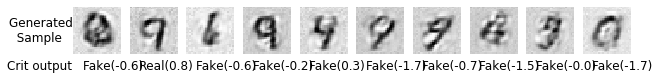

  0%|          | 2/469 [00:00<00:43, 10.64it/s]

Epoch 127


100%|██████████| 469/469 [00:41<00:00, 11.02it/s]


g loss: 0.260020661463679
dr loss: -1.4656510237437577
df loss: -0.23015298389557645


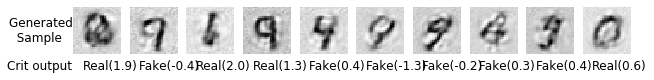

  0%|          | 2/469 [00:00<00:45, 10.30it/s]

Epoch 128


100%|██████████| 469/469 [00:41<00:00, 11.21it/s]


g loss: 0.10595243098512133
dr loss: -1.5902011153032023
df loss: -0.09472669796275496


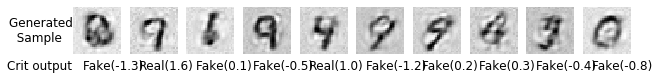

  0%|          | 2/469 [00:00<00:45, 10.35it/s]

Epoch 129


100%|██████████| 469/469 [00:41<00:00, 11.19it/s]


g loss: 0.12394975694114847
dr loss: -1.582717288785906
df loss: -0.10519603411279825


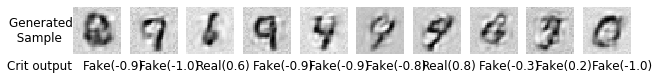

  0%|          | 2/469 [00:00<00:45, 10.35it/s]

Epoch 130


100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


g loss: 0.0546720994314723
dr loss: -1.6555434875905133
df loss: -0.03372202182351463


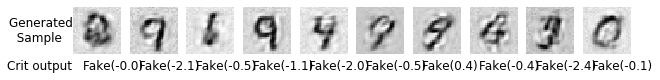

  0%|          | 2/469 [00:00<00:45, 10.27it/s]

Epoch 131


100%|██████████| 469/469 [00:41<00:00, 11.29it/s]


g loss: -0.2124909340127953
dr loss: -1.9364357934172538
df loss: 0.24111890988047124


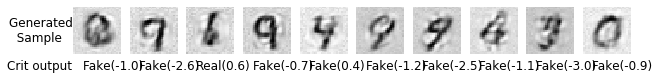

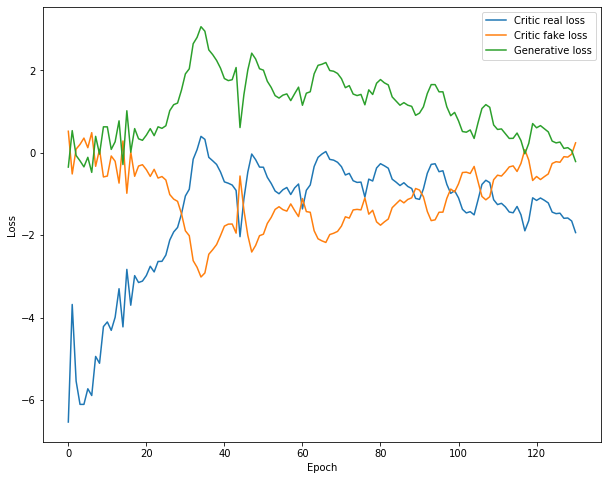

  0%|          | 2/469 [00:00<00:45, 10.37it/s]

Epoch 132


100%|██████████| 469/469 [00:42<00:00, 11.08it/s]


g loss: 0.21218998623745783
dr loss: -1.636471939052759
df loss: -0.14740682016017595


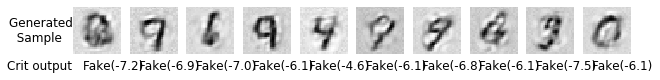

  0%|          | 2/469 [00:00<00:45, 10.23it/s]

Epoch 133


100%|██████████| 469/469 [00:41<00:00, 11.22it/s]


g loss: -0.15973394432825958
dr loss: -1.9357298449682656
df loss: 0.21135094660177414


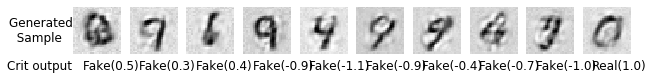

  0%|          | 2/469 [00:00<00:44, 10.51it/s]

Epoch 134


100%|██████████| 469/469 [00:41<00:00, 11.02it/s]


g loss: 0.32490657102356335
dr loss: -1.371558504824493
df loss: -0.30774930918585264


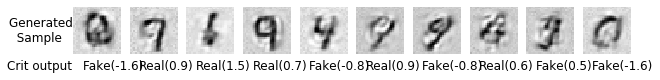

  0%|          | 2/469 [00:00<00:46, 10.11it/s]

Epoch 135


100%|██████████| 469/469 [00:42<00:00, 11.12it/s]


g loss: 0.5897848383048927
dr loss: -1.095527595818551
df loss: -0.5758373004489584


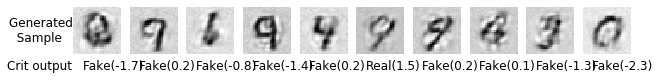

  0%|          | 2/469 [00:00<00:46, 10.08it/s]

Epoch 136


100%|██████████| 469/469 [00:42<00:00, 11.12it/s]


g loss: 0.5080623139958901
dr loss: -1.1550963116861355
df loss: -0.4981286551700091


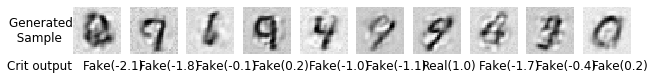

  0%|          | 2/469 [00:00<00:45, 10.22it/s]

Epoch 137


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


g loss: 0.42454512368863834
dr loss: -1.242953506232833
df loss: -0.41732270899278395


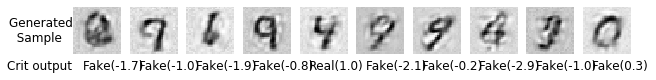

  0%|          | 2/469 [00:00<00:45, 10.17it/s]

Epoch 138


100%|██████████| 469/469 [00:42<00:00, 11.06it/s]


g loss: 0.43405394379629386
dr loss: -1.2265037467230613
df loss: -0.42133840579372733


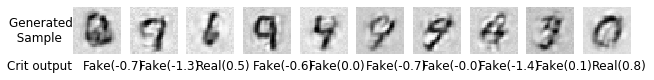

  0%|          | 2/469 [00:00<00:45, 10.25it/s]

Epoch 139


100%|██████████| 469/469 [00:41<00:00, 11.20it/s]


g loss: 0.3252085820158153
dr loss: -1.344312170802403
df loss: -0.3018634127560201


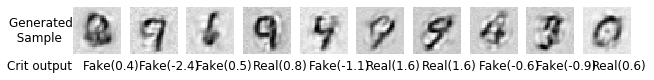

  0%|          | 2/469 [00:00<00:45, 10.21it/s]

Epoch 140


100%|██████████| 469/469 [00:41<00:00, 11.30it/s]


g loss: 0.14800594936905387
dr loss: -1.4689726419032
df loss: -0.14060139750192033


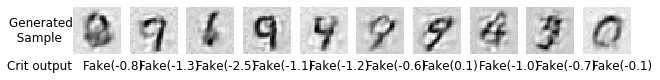

  0%|          | 2/469 [00:00<00:44, 10.55it/s]

Epoch 141


100%|██████████| 469/469 [00:41<00:00, 11.46it/s]


g loss: 0.0970743494287038
dr loss: -1.5470355024724118
df loss: -0.0808826029272889


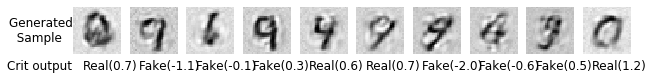

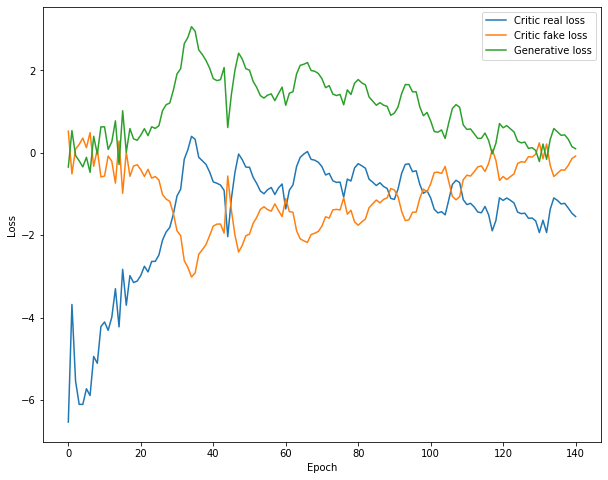

  0%|          | 2/469 [00:00<00:44, 10.41it/s]

Epoch 142


100%|██████████| 469/469 [00:41<00:00, 11.25it/s]


g loss: 0.07800542606489617
dr loss: -1.5684373310125712
df loss: -0.06314837751286562


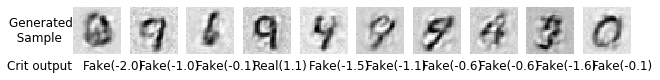

  0%|          | 2/469 [00:00<00:44, 10.38it/s]

Epoch 143


100%|██████████| 469/469 [00:41<00:00, 11.24it/s]


g loss: 0.1741235359792294
dr loss: -1.4675158868466358
df loss: -0.1448483738893353


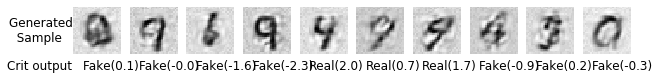

  0%|          | 2/469 [00:00<00:45, 10.33it/s]

Epoch 144


100%|██████████| 469/469 [00:41<00:00, 11.37it/s]


g loss: -0.053036440092363336
dr loss: -1.6905754757588352
df loss: 0.07649287136235852


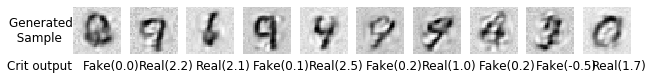

  0%|          | 2/469 [00:00<00:44, 10.51it/s]

Epoch 145


100%|██████████| 469/469 [00:41<00:00, 11.52it/s]


g loss: -0.1660108226718806
dr loss: -1.836647809199147
df loss: 0.2099424361555116


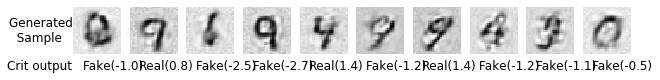

  0%|          | 2/469 [00:00<00:45, 10.36it/s]

Epoch 146


100%|██████████| 469/469 [00:42<00:00, 11.11it/s]


g loss: 0.4344597752732255
dr loss: -1.297143023941658
df loss: -0.38049425259391384


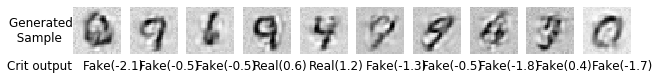

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 147


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


g loss: -0.5815299764783907
dr loss: -2.3021689091346413
df loss: 0.6242098333611925


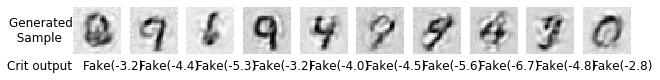

  0%|          | 2/469 [00:00<00:45, 10.29it/s]

Epoch 148


100%|██████████| 469/469 [00:41<00:00, 11.23it/s]


g loss: -0.16806096906886936
dr loss: -1.8477634491998631
df loss: 0.21175600418340423


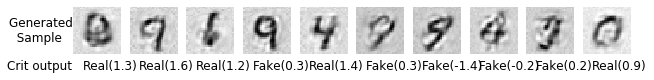

  0%|          | 2/469 [00:00<00:45, 10.35it/s]

Epoch 149


100%|██████████| 469/469 [00:41<00:00, 11.24it/s]


g loss: 0.3571474952484245
dr loss: -1.2532094510506466
df loss: -0.35294765760617725


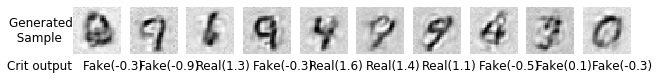

  0%|          | 2/469 [00:00<00:46, 10.10it/s]

Epoch 150


100%|██████████| 469/469 [00:41<00:00, 11.23it/s]


g loss: 0.3139629308829334
dr loss: -1.3151530525577602
df loss: -0.29305406522029626


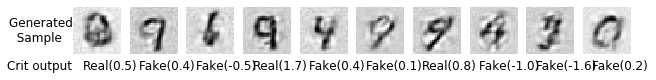

  0%|          | 2/469 [00:00<00:46, 10.15it/s]

Epoch 151


100%|██████████| 469/469 [00:42<00:00, 11.16it/s]


g loss: 0.15754836109051826
dr loss: -1.4484316466459588
df loss: -0.13560153544942008


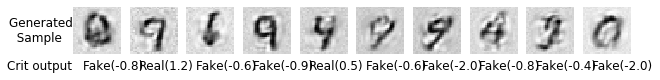

  0%|          | 2/469 [00:00<00:45, 10.20it/s]

Epoch 152


100%|██████████| 469/469 [00:41<00:00, 11.28it/s]


g loss: 0.10648605503094222
dr loss: -1.505559717668399
df loss: -0.08147234979397389


  0%|          | 2/469 [00:00<00:45, 10.35it/s]

Epoch 153


100%|██████████| 469/469 [00:42<00:00, 11.31it/s]


g loss: 0.044168700644774225
dr loss: -1.5480723968192713
df loss: -0.026079671814847095


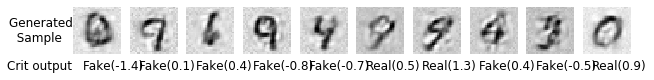

  0%|          | 2/469 [00:00<00:45, 10.21it/s]

Epoch 154


100%|██████████| 469/469 [00:42<00:00, 11.64it/s]


g loss: -0.023505768315719645
dr loss: -1.622578251336429
df loss: 0.03698024538351592


  0%|          | 2/469 [00:00<00:44, 10.42it/s]

Epoch 155


100%|██████████| 469/469 [00:41<00:00, 11.44it/s]


g loss: 0.016549653423302717
dr loss: -1.5619388717069809
df loss: -0.006329841903849705


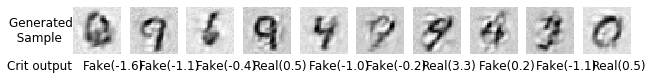

  0%|          | 2/469 [00:00<00:45, 10.24it/s]

Epoch 156


100%|██████████| 469/469 [00:41<00:00, 11.24it/s]


g loss: -0.07328419786280216
dr loss: -1.64821440883791
df loss: 0.08102330963796517


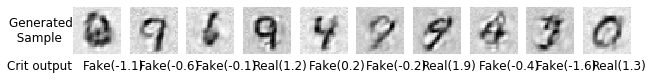

  0%|          | 2/469 [00:00<00:44, 10.50it/s]

Epoch 157


100%|██████████| 469/469 [00:41<00:00, 10.85it/s]


g loss: 0.043918652686355975
dr loss: -1.5501032592391155
df loss: -0.020939504274967383


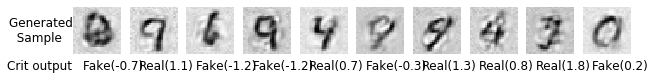

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 158


100%|██████████| 469/469 [00:42<00:00, 11.06it/s]


g loss: -0.10233541499815389
dr loss: -1.688834590825445
df loss: 0.12643848457085743


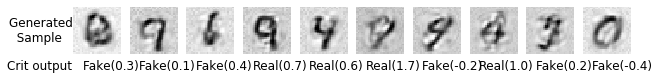

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 159


100%|██████████| 469/469 [00:42<00:00, 11.11it/s]


g loss: -0.21159037484972082
dr loss: -1.8047278234953565
df loss: 0.22781865650029387


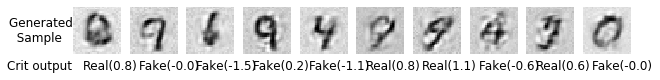

  0%|          | 2/469 [00:00<00:45, 10.30it/s]

Epoch 160


100%|██████████| 469/469 [00:41<00:00, 11.18it/s]


g loss: -0.2183399177881192
dr loss: -1.8618253968806981
df loss: 0.24684796816726992


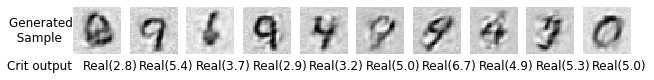

  0%|          | 2/469 [00:00<00:44, 10.53it/s]

Epoch 161


100%|██████████| 469/469 [00:41<00:00, 10.99it/s]


g loss: 0.1945750949892408
dr loss: -1.420080237130303
df loss: -0.1698848207526878


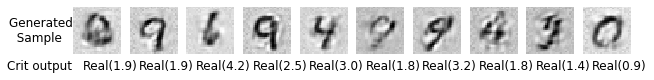

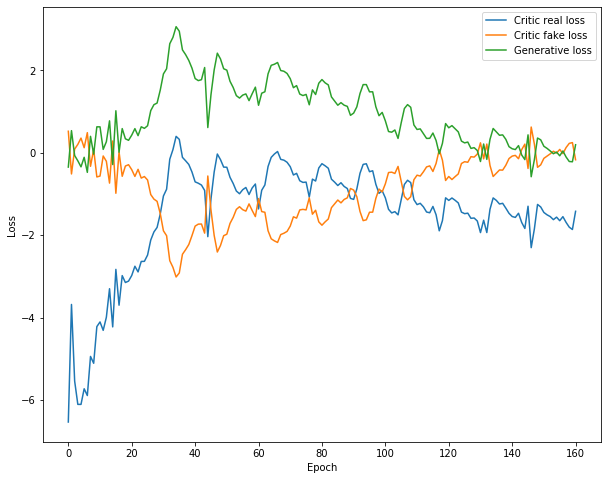

  0%|          | 2/469 [00:00<00:46, 10.09it/s]

Epoch 162


100%|██████████| 469/469 [00:42<00:00, 11.08it/s]


g loss: -0.06266485339701812
dr loss: -1.662375885611976
df loss: 0.0750626669898788


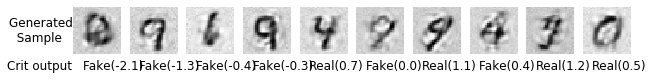

  0%|          | 2/469 [00:00<00:44, 10.53it/s]

Epoch 163


100%|██████████| 469/469 [00:42<00:00, 11.08it/s]


g loss: 0.5392495191880444
dr loss: -1.0466623327244065
df loss: -0.524113573020757


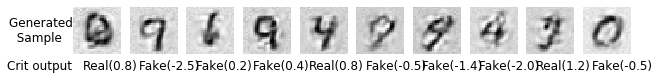

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 164


100%|██████████| 469/469 [00:43<00:00, 10.88it/s]


g loss: 0.4415261390001408
dr loss: -1.150843889728538
df loss: -0.3956973738174067


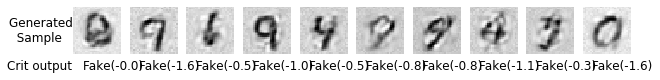

  0%|          | 2/469 [00:00<00:45, 10.31it/s]

Epoch 165


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


g loss: 0.24280948435335653
dr loss: -1.3094545489689435
df loss: -0.22888885582410007


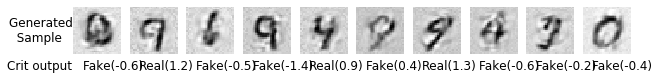

  0%|          | 2/469 [00:00<00:45, 10.33it/s]

Epoch 166


100%|██████████| 469/469 [00:42<00:00, 11.16it/s]


g loss: 0.23361091611227755
dr loss: -1.3380180705330773
df loss: -0.20527666179177317


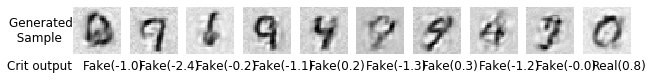

  0%|          | 2/469 [00:00<00:45, 10.17it/s]

Epoch 167


100%|██████████| 469/469 [00:42<00:00, 11.08it/s]


g loss: 0.08091473918177808
dr loss: -1.4524226301768695
df loss: -0.0937130934775257


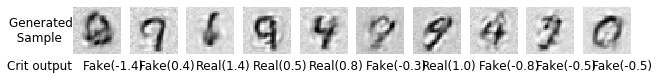

  0%|          | 2/469 [00:00<00:44, 10.61it/s]

Epoch 168


100%|██████████| 469/469 [00:42<00:00, 11.52it/s]


g loss: 0.05946975886456367
dr loss: -1.4695472047527207
df loss: -0.05786406943229025


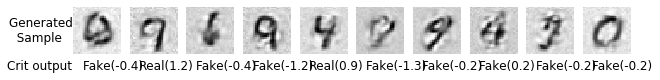

  0%|          | 2/469 [00:00<00:44, 10.39it/s]

Epoch 169


100%|██████████| 469/469 [00:41<00:00, 11.09it/s]


g loss: 0.05226051917414803
dr loss: -1.4880796081221688
df loss: -0.03992380822963044


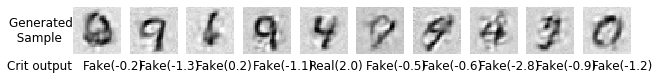

  0%|          | 2/469 [00:00<00:44, 10.47it/s]

Epoch 170


100%|██████████| 469/469 [00:41<00:00, 11.24it/s]


g loss: 0.019062221455357985
dr loss: -1.5168708170146576
df loss: 0.007466867550222604


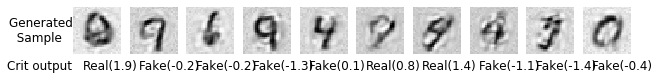

  0%|          | 2/469 [00:00<00:45, 10.23it/s]

Epoch 171


100%|██████████| 469/469 [00:42<00:00, 11.03it/s]


g loss: -0.15363664398077073
dr loss: -1.7025616308773504
df loss: 0.1812795752576038


  0%|          | 2/469 [00:00<00:45, 10.30it/s]

Epoch 172


100%|██████████| 469/469 [00:42<00:00, 11.06it/s]


g loss: -0.10301217643309758
dr loss: -1.627656662133711
df loss: 0.1243048355575087


  0%|          | 2/469 [00:00<00:45, 10.27it/s]

Epoch 173


100%|██████████| 469/469 [00:41<00:00, 11.53it/s]


g loss: -0.07264652980495491
dr loss: -1.6247197892874288
df loss: 0.10646827482203366


  0%|          | 2/469 [00:00<00:45, 10.34it/s]

Epoch 174


100%|██████████| 469/469 [00:41<00:00, 11.61it/s]


g loss: 0.20356611426133336
dr loss: -1.3727278266745462
df loss: -0.17092055080732557


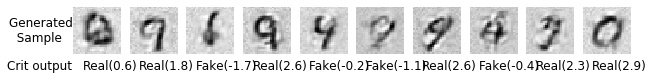

  0%|          | 2/469 [00:00<00:43, 10.66it/s]

Epoch 175


100%|██████████| 469/469 [00:41<00:00, 11.33it/s]


g loss: -0.3211619409480329
dr loss: -1.9657055326957884
df loss: 0.3669899507387996


  0%|          | 2/469 [00:00<00:44, 10.45it/s]

Epoch 176


100%|██████████| 469/469 [00:41<00:00, 11.36it/s]


g loss: -0.43579781424007946
dr loss: -1.9810458509239561
df loss: 0.4527692814180846


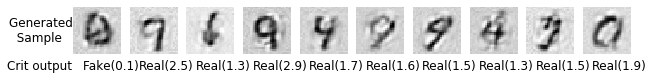

  0%|          | 2/469 [00:00<00:44, 10.48it/s]

Epoch 177


100%|██████████| 469/469 [00:41<00:00, 11.27it/s]


g loss: 0.18302469969049953
dr loss: -1.3360503187764492
df loss: -0.17571551479033823


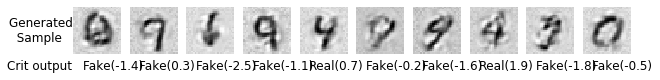

  0%|          | 2/469 [00:00<00:45, 10.23it/s]

Epoch 178


 75%|███████▍  | 350/469 [00:31<00:10, 11.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 469/469 [00:41<00:00, 11.27it/s]


g loss: 0.21530701339975603
dr loss: -1.3017561556433819
df loss: -0.19339490648327287


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 181


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


g loss: 0.05012617188333067
dr loss: -1.457056407608203
df loss: -0.03074184293225249


  0%|          | 2/469 [00:00<00:44, 10.60it/s]

Epoch 182


100%|██████████| 469/469 [00:41<00:00, 11.30it/s]


g loss: 0.06329972526308761
dr loss: -1.4327245067431729
df loss: -0.06261523646403795


  0%|          | 2/469 [00:00<00:45, 10.25it/s]

Epoch 185


100%|██████████| 469/469 [00:42<00:00, 11.12it/s]


g loss: 0.15247876670505447
dr loss: -1.3568863065512196
df loss: -0.11692942953757894


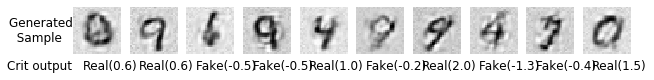

  0%|          | 2/469 [00:00<00:45, 10.22it/s]

Epoch 186


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


g loss: -0.036329438419404954
dr loss: -1.521930233247753
df loss: 0.05208412944269714


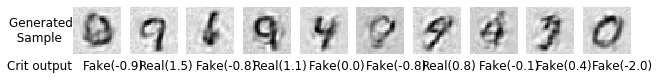

  0%|          | 2/469 [00:00<00:44, 10.58it/s]

Epoch 187


100%|██████████| 469/469 [00:41<00:00, 11.27it/s]


g loss: -0.0993488471645282
dr loss: -1.5928933046011529
df loss: 0.11829050230398488


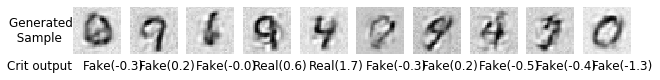

  0%|          | 2/469 [00:00<00:44, 10.54it/s]

Epoch 188


100%|██████████| 469/469 [00:41<00:00, 11.40it/s]


g loss: -0.11628135788574148
dr loss: -1.6104745600523471
df loss: 0.1330372017444864


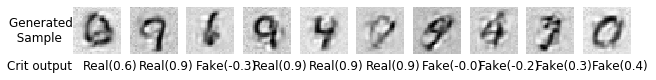

  0%|          | 2/469 [00:00<00:45, 10.23it/s]

Epoch 189


100%|██████████| 469/469 [00:41<00:00, 11.28it/s]


g loss: -0.10539223767642274
dr loss: -1.5851097395425158
df loss: 0.1156082551286959


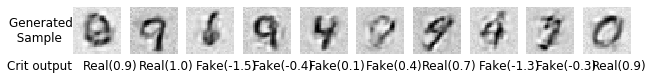

  0%|          | 2/469 [00:00<00:44, 10.56it/s]

Epoch 190


100%|██████████| 469/469 [00:41<00:00, 11.37it/s]


g loss: -0.37148724955472867
dr loss: -1.8599464646788801
df loss: 0.39462603619798764


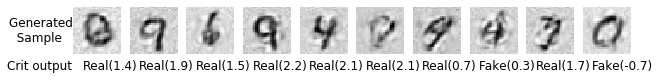

  0%|          | 2/469 [00:00<00:45, 10.19it/s]

Epoch 191


100%|██████████| 469/469 [00:41<00:00, 11.19it/s]


g loss: -0.3033172742509321
dr loss: -1.8076523841857148
df loss: 0.3200421380931571


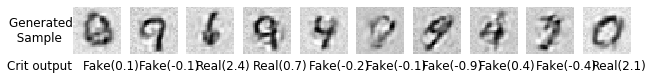

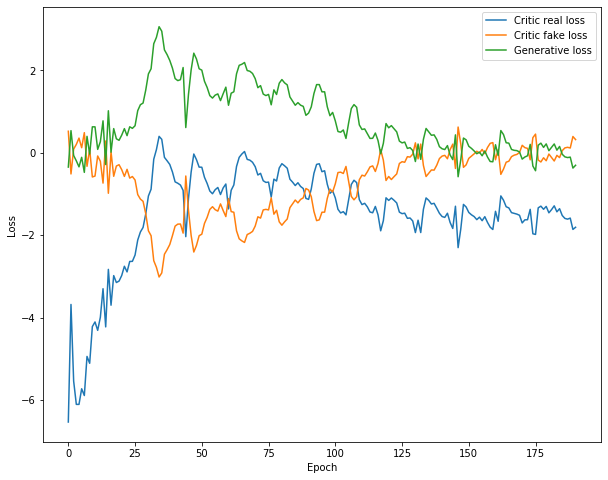

  0%|          | 2/469 [00:00<00:46, 10.15it/s]

Epoch 192


100%|██████████| 469/469 [00:42<00:00, 11.07it/s]


g loss: 0.09767312627992651
dr loss: -1.5008521592820376
df loss: -0.06311580236516655


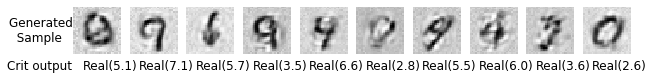

  0%|          | 2/469 [00:00<00:45, 10.20it/s]

Epoch 193


100%|██████████| 469/469 [00:42<00:00, 11.04it/s]


g loss: -0.5395493507861837
dr loss: -2.0860384104411995
df loss: 0.59234393073091


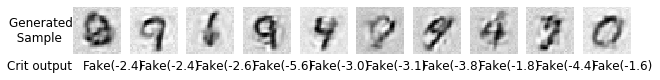

  0%|          | 2/469 [00:00<00:44, 10.43it/s]

Epoch 194


100%|██████████| 469/469 [00:42<00:00, 11.13it/s]


g loss: 0.16471994480789343
dr loss: -1.3114112608754305
df loss: -0.14564662982723606


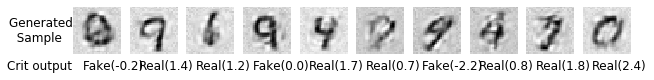

  0%|          | 2/469 [00:00<00:45, 10.20it/s]

Epoch 195


100%|██████████| 469/469 [00:42<00:00, 11.11it/s]


g loss: -0.00955024982359745
dr loss: -1.4798220477378699
df loss: 0.025749159692875993


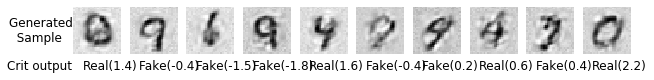

  0%|          | 2/469 [00:00<00:46, 10.05it/s]

Epoch 196


100%|██████████| 469/469 [00:42<00:00, 11.07it/s]


g loss: 0.1296723744710848
dr loss: -1.3418861317482076
df loss: -0.12292855299675642


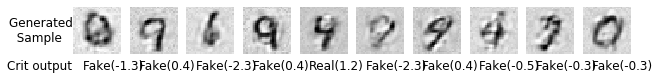

  0%|          | 2/469 [00:00<00:45, 10.32it/s]

Epoch 197


 38%|███▊      | 180/469 [00:16<00:25, 11.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
Dr_losses = []
Df_losses = []
G_losses = []

num_critic = 5
gp_weight = 10

def train():
    for i in range(200):
        print("Epoch %d" % (i + 1))
        Dr_loss = 0
        Df_loss = 0
        G_loss = 0
        lenX = len(X_loaded)
        for batch_ndx, data in tqdm(enumerate(X_loaded), total=lenX):
            data = data[0].to(device).view(-1, 784)

            D_loss = train_D(data)
            Dr_loss += D_loss[0]
            Df_loss += D_loss[1]

            if((batch_ndx - 1) % num_critic == 0):
                G_loss += train_G(data)
            
        Dr_losses.append(Dr_loss / lenX)
        Df_losses.append(Df_loss / lenX)
        G_losses.append(G_loss / (lenX /num_critic))

        print("g loss: " + str(G_losses[-1]))
        print("dr loss: " + str(Dr_losses[-1]))
        print("df loss: " + str(Df_losses[-1]))

        plotGeneratedImages()
        
        if (i%10==0):
            plotLoss()

train()